In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
auctions = DataFetcher()
auctions.fetch_auction_data()

,cusip,auction_date,issue_date,security_term,maturity_date,avg_med_yield,currently_outstanding,original_security_term
0,91282CNB3,2025-06-17,2025-06-30,4-Year 10-Month,2030-04-15,null,26711000000.000000,5-Year
1,912797PG6,2025-06-17,2025-06-20,6-Week,2025-07-31,null,160724000000.000000,26-Week
2,912810UL0,2025-06-16,2025-06-30,19-Year 11-Month,2045-05-15,null,18189000000.000000,20-Year
3,912797QZ3,2025-06-16,2025-06-20,26-Week,2025-12-18,null,null,26-Week
4,912797PX9,2025-06-16,2025-06-20,13-Week,2025-09-18,null,68187000000.000000,26-Week
...,...,...,...,...,...,...,...,...
65,9127935W2,1980-01-02,1980-01-08,52-Week,1981-01-02,null,null,52-Week
66,9127933Y0,1979-12-28,1980-01-03,13-Week,1980-04-03,null,null,null
67,9127934U7,1979-12-28,1980-01-03,26-Week,1980-07-03,null,null,26-Week
68,912810CK2,1979-11-01,1979-11-15,30-Year,2009-11-15,10.440000,null,30-Year


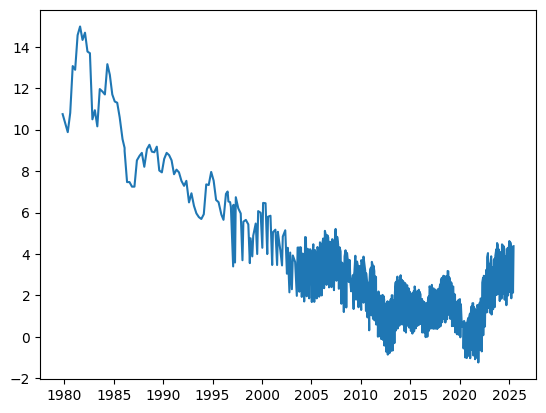

In [3]:
data = auctions.auction_data
yields_over_time = data[data['original_security_term'] == '10-Year'][['auction_date', 'avg_med_yield']]
yields_over_time['auction_date'] = pd.to_datetime(yields_over_time['auction_date'])
yields_over_time['avg_med_yield'] = pd.to_numeric(yields_over_time['avg_med_yield'], errors='coerce')

plt.plot(yields_over_time['auction_date'], yields_over_time['avg_med_yield'], linestyle='-')
plt.show()

In [4]:
usts = USTs(auction_data=data, price_data=None, curve_data=None)
otr = usts.get_nth_OTRs(4)
otr

/workspaces/RV/USTs.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['run'] = 0


,cusip,auction_date,security_term,avg_med_yield,maturity_date,run
0,91282CNE7,2025-05-27,2-Year,3.900000,2027-05-31,1
1,91282CMX6,2025-04-23,2-Year,null,2027-04-30,2
2,91282CMY4,2025-04-22,2-Year,3.740000,2027-04-30,3
3,91282CMV0,2025-03-25,2-Year,3.936000,2027-03-31,4
4,91282CNH0,2025-06-10,3-Year,3.919000,2028-06-15,1
5,91282CND9,2025-05-05,3-Year,3.769000,2028-05-15,2
6,91282CMW8,2025-04-08,3-Year,3.700000,2028-04-15,3
7,91282CMS7,2025-03-11,3-Year,3.850000,2028-03-15,4
8,91282CNG2,2025-05-28,5-Year,4.010000,2030-05-31,1
9,91282CMZ1,2025-04-23,5-Year,3.928000,2030-04-30,2


In [8]:
otr['maturity_date'] = pd.to_datetime(otr['maturity_date'])
otr['avg_med_yield'] = pd.to_numeric(otr['avg_med_yield'], errors='coerce')

<Axes: xlabel='maturity_date', ylabel='avg_med_yield'>

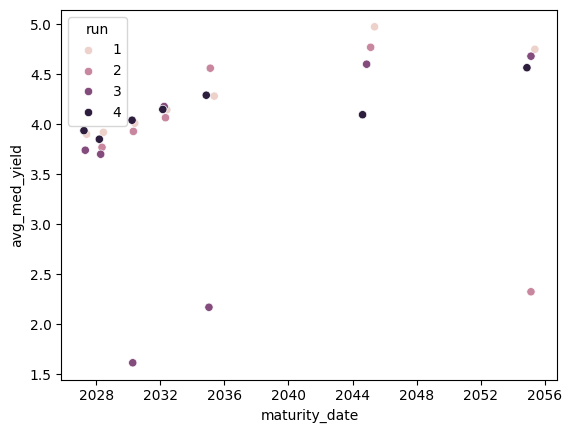

In [11]:
sns.scatterplot(data=otr, x='maturity_date', y='avg_med_yield', hue='run')